# Conditional Graph - Multi-Path Workflow

This notebook demonstrates a LangGraph workflow with conditional branching. Based on the target currency specified in the input, the graph takes different paths to convert USD to either INR or EUR.

## Step 1: Import Required Libraries

Import the necessary modules for building the state graph and displaying visualizations.

In [12]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

## Step 2: Define the State Structure

Define the `PortfolioState` TypedDict that represents the state passed through the workflow:
- `amount_usd`: Initial USD amount
- `total_usd`: USD amount after applying the 8% factor
- `target_currency`: The currency to convert to (INR or EUR)
- `total`: Final converted amount

In [13]:
class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    target_currency: Literal['INR', 'EUR']
    total: float


## Step 3: Define Processing Functions

Define the workflow nodes:
- `calc_total()`: Calculates total USD by applying an 8% factor
- `convert_to_inr()`: Converts USD to Indian Rupees (1 USD = 85 INR)
- `convert_to_eur()`: Converts USD to Euro (1 USD = 0.9 EUR)
- `choose_conversion()`: Routing function that determines which conversion path to take based on target_currency

In [14]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08  
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 85.0  
    return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.9  
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state['target_currency']

## Step 4: Build the State Graph with Conditional Routing

Create the graph with:
1. Three nodes: calc_total_usd, convert_to_inr, convert_to_eur
2. A linear edge from START to calc_total_usd
3. Conditional edges from calc_total_usd that route to either convert_to_inr or convert_to_eur based on the target_currency
4. Edges from both conversion nodes to END

In [15]:
builder = StateGraph(PortfolioState)

builder.add_node("calc_total_usd", calc_total)
builder.add_node("convert_to_inr", convert_to_inr)
builder.add_node("convert_to_eur", convert_to_eur)

builder.add_edge(START, "calc_total_usd")
builder.add_conditional_edges("calc_total_usd", choose_conversion, 
    {
    "INR": "convert_to_inr", 
    "EUR": "convert_to_eur"
    }
)
builder.add_edge(["convert_to_inr", "convert_to_eur"], END)

graph = builder.compile()

## Step 5: Visualize the Graph

Display the compiled graph as a Mermaid diagram to see the workflow structure including the conditional branching.

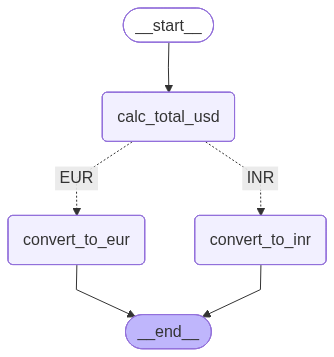

In [16]:
# Display the graph visualization
image_data = graph.get_graph().draw_mermaid_png()
display(Image(image_data))

## Step 6: Execute Graph with INR Conversion

Invoke the graph with $1000 USD and request conversion to Indian Rupees (INR). The workflow will:
1. Calculate total USD: 1000 * 1.08 = 1080
2. Route to convert_to_inr node
3. Convert to INR: 1080 * 85.0 = 91800

In [17]:
graph.invoke({'amount_usd': 1000, 'target_currency': 'INR'})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'INR',
 'total': 91800.0}

## Step 7: Execute Graph with EUR Conversion

Invoke the graph with $1000 USD and request conversion to Euro (EUR). The workflow will:
1. Calculate total USD: 1000 * 1.08 = 1080
2. Route to convert_to_eur node (different path than INR)
3. Convert to EUR: 1080 * 0.9 = 972

In [18]:
graph.invoke({'amount_usd': 1000, 'target_currency': 'EUR'})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'EUR',
 'total': 972.0}